#### 5 year Forecasting With Online Sales


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import pyodbc 
import pandas as pd
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4P75PCB;'
                      'Database=AdventureWorks2012;' 
                      'Trusted_Connection=yes;')


sql_for_df1 = """SELECT SOH.[OrderDate],CASE WHEN SOH.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel,
                SO.[OrderQty]*SO.[UnitPrice] AS Total_Sales,
                ST.Name AS Region 
                FROM [Sales].[SalesOrderDetail] AS SO \
                INNER JOIN [Sales].[SalesOrderHeader] AS SOH \
                ON SO.SalesOrderID = SOH.SalesOrderID \
                INNER JOIN [Production].[Product] AS PP \
                ON SO.[ProductID] = PP.ProductID \
                INNER JOIN  [Production].[ProductSubcategory] AS PSC \
                ON PP.[ProductSubcategoryID] = PSC.[ProductSubcategoryID] \
                INNER JOIN [Production].[ProductCategory] AS PC \
                ON PSC.[ProductCategoryID] = PC.[ProductCategoryID] \
                INNER JOIN [Sales].[SalesTerritory] AS ST \
                ON ST.TerritoryID =SOH.TerritoryID \
                WHERE OnlineOrderFlag = '1' """

df = pd.read_sql(sql_for_df1 , conn)


conn.close()
df.head()

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia


In [3]:
df = pd.DataFrame(df)
df.reset_index(drop=True, inplace=True)
df


,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia
...,...,...,...,...
60393,2014-06-30,Online,21.9800,Canada
60394,2014-06-30,Online,8.9900,Canada
60395,2014-06-30,Online,21.9800,Canada
60396,2014-06-30,Online,159.0000,Canada


In [4]:
df.OrderDate.max() 

Timestamp('2014-06-30 00:00:00')

In [5]:
df.OrderDate.min()

Timestamp('2011-05-31 00:00:00')

In [6]:
#df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [7]:
online_channel= df.loc[df['Region'] == 'Germany',:]
online_channel

,OrderDate,Sales_Channel,Total_Sales,Region
15,2011-06-03,Online,3578.27,Germany
23,2011-06-05,Online,3578.27,Germany
28,2011-06-07,Online,3578.27,Germany
40,2011-06-10,Online,3578.27,Germany
55,2011-06-13,Online,3578.27,Germany
...,...,...,...,...
60376,2014-06-30,Online,54.99,Germany
60380,2014-06-30,Online,4.99,Germany
60381,2014-06-30,Online,2.29,Germany
60382,2014-06-30,Online,7.95,Germany


### Data Preprocessing

In [8]:
cols = ['Sales_Channel','Region']
online_channel.drop(cols, axis=1, inplace=True)
online_channel = online_channel.sort_values('OrderDate')
online_channel.isnull().sum()


OrderDate      0
Total_Sales    0
dtype: int64

In [9]:
online_channel = online_channel.groupby('OrderDate')['Total_Sales'].sum().reset_index()
online_channel

,OrderDate,Total_Sales
0,2011-06-03,3578.27
1,2011-06-05,3578.27
2,2011-06-07,3578.27
3,2011-06-10,3578.27
4,2011-06-13,3578.27
...,...,...
730,2014-06-25,91.74
731,2014-06-26,156.91
732,2014-06-27,78.96
733,2014-06-28,390.86


### Indexing with Time Series Data

In [10]:
online_channel = online_channel.set_index('OrderDate')
online_channel.index

DatetimeIndex(['2011-06-03', '2011-06-05', '2011-06-07', '2011-06-10',
               '2011-06-13', '2011-06-15', '2011-06-19', '2011-06-21',
               '2011-06-25', '2011-06-30',
               ...
               '2014-06-18', '2014-06-19', '2014-06-21', '2014-06-22',
               '2014-06-23', '2014-06-25', '2014-06-26', '2014-06-27',
               '2014-06-28', '2014-06-30'],
              dtype='datetime64[ns]', name='OrderDate', length=735, freq=None)

current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [11]:
y = online_channel['Total_Sales'].resample('MS').mean()
y = y.fillna(y.bfill())

In [12]:
y['2014':]

OrderDate
2014-01-01    4825.756129
2014-02-01    5946.378846
2014-03-01    6338.983548
2014-04-01    6586.620333
2014-05-01    6900.480000
2014-06-01     138.224000
Freq: MS, Name: Total_Sales, dtype: float64

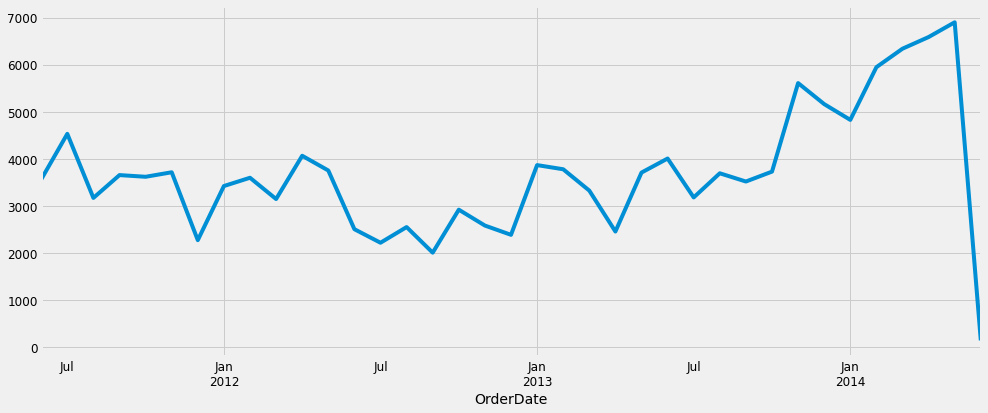

In [13]:
#Visualizing Country Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

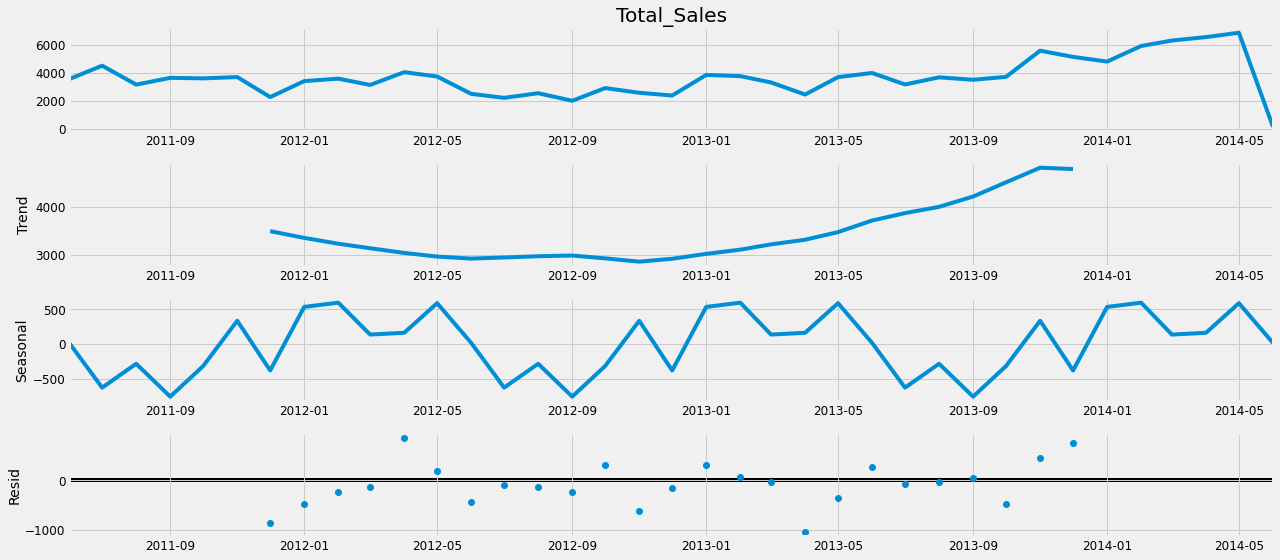

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [16]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:700.1515424975844
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:923.115032193004
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:434.55089830557387
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:226.01888962659243
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:453.27025061304494
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:429.3126681084644
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:238.5346089149705
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:215.0385780545794
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:647.2116527488191
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1870.0154128805136
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:408.3421892285561
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:204.2689448866752
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:445.4943806952877
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:410.7989390678246
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:235.7697643335065
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:195.6384158319925
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:607.4504469092899
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:408.3614513057188
ARIMA(0

 ### Fitting an ARIMA Time Series Model

In [17]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1750      2.172     -0.081      0.936      -4.433       4.083
ma.L1         -0.1432      1.903     -0.075      0.940      -3.874       3.587
ar.S.L12      -1.7172      0.521     -3.297      0.001      -2.738      -0.696
ma.S.L12       1.3553      1.076      1.259      0.208      -0.754       3.465
sigma2      1.245e+06   1.06e-06   1.18e+12      0.000    1.25e+06    1.25e+06


### Validating forecasts

In [18]:
#pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred = results.get_prediction(start=pd.to_datetime('2011-06-01'), end=pd.to_datetime('2014-06-30 05:40:00'),dynamic=True, full_results=True)
pred_ci = pred.conf_int()


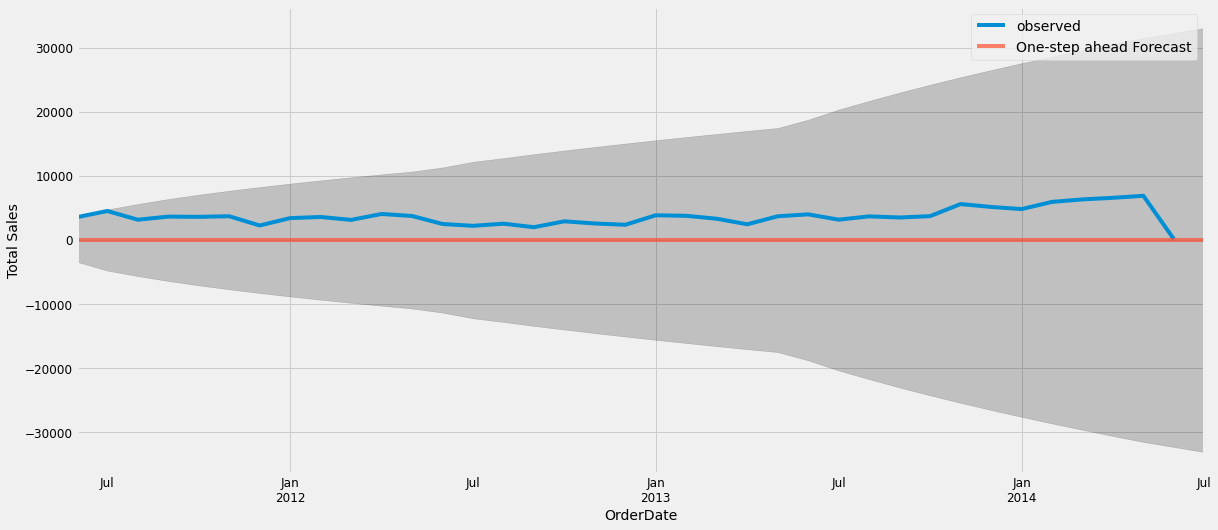

In [19]:
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()

plt.show()

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-06-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 19105.87


In [21]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 138.22


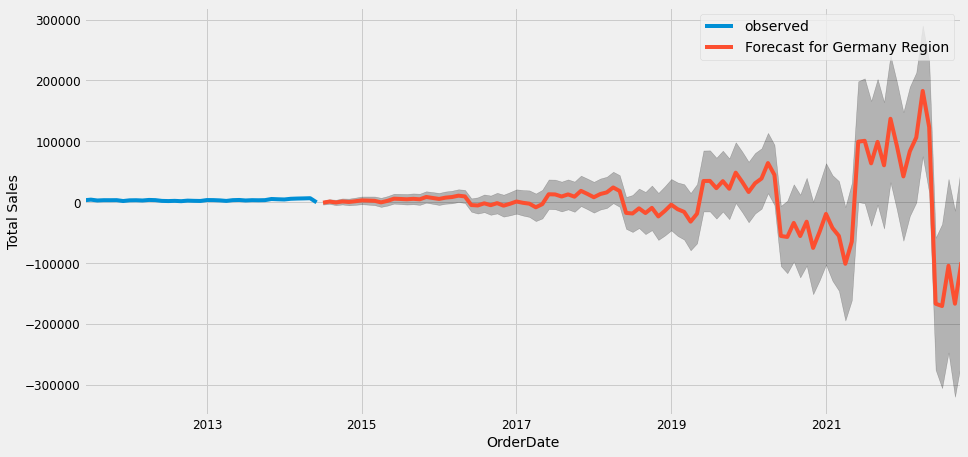

In [22]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast for Germany Region')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()
plt.show()